# Movie rating Recommendation system

## Business Understanding

In the modern entertainment industry, consumers are overwhelmed by vast libraries of movies across streaming platforms, theaters, and rental services. With thousands of titles available, finding relevant and engaging content can be challenging.

The goal is to provide movie recommendations to users based on their past ratings, improvin user engagement and satisfactions. Additionally, I will aim to address the cold start problem to recommend movies for new users or movies with limited data.

## Data Understanding

The MovieLens dataset is used, which contains 100K,836 explicit user ratings for movies along with metdata such as 9,743 titles, genres, and timestamps. Users were selected at random for inclusion. This dataset allows us to analyze user preferences and create a recommendation system.This dataset is particularly suitable for this project because:

* It contains explicit user feedback in the form of ratings, making it ideal for collaborative filtering approaches.
* It provides metadata about movies (e.g., genres, titles, release years), enabling the potential inclusion of content-based and hybrid recommendation techniques.
* It has been extensively used in academic and industry research, ensuring reliability and well-documented best practices.

In this project, we have 3 seperate datasets that can be included
* links.csv: Identifiers that can be used to link to other sources of movie data are contained in the file.
* movies.csv: Provides metadata such as movie titles and genres.
* ratings.csv: Contains user-movie interactions with explicit ratings.

While the dataset is highly useful, several limitations must be considered:

* **Sparsity**: The dataset contains a high number of missing ratings, making it challenging to infer preferences for less active users. Techniques such as matrix factorization and nearest-neighbor models can mitigate this issue.

* **Cold Start Problem**:
* **New users**: Without sufficient rating history, it is difficult to provide personalized recommendations. Hybrid models incorporating content-based methods can help.
* **New movies**: Unrated movies struggle to be recommended until they accumulate sufficient feedback.
* **Bias in Ratings**:
Some movies receive significantly more ratings than others, potentially skewing recommendations.
Users may have varying rating scales (e.g., some users rarely give 5-star ratings). Normalization techniques can address this.

## Data Preparartion

 I'll start by inspecting the contents of these files to understand their structure and proceed with building the movie recommendation system.

 I'll import the necessary libraries for this project, which includes the **Surprise** library.

In [1]:
#import neccesary libraries 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#import neccessary libraries from the surprise library
from surprise import SVD, Dataset, Reader
from surprise.model_selection import train_test_split
from surprise import accuracy
from surprise.model_selection import cross_validate, GridSearchCV
from surprise.prediction_algorithms import KNNBaseline, KNNBasic, KNNWithMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error

In [2]:
# save each CSV file into variables.

links_df = pd.read_csv('../data/links.csv')
movies_df = pd.read_csv('../data/movies.csv')
ratings_df = pd.read_csv('../data/ratings.csv')


In [3]:
# print the head of each dataset

links_df_head = links_df.head()
movies_df_head = movies_df.head()
ratings_df_head = ratings_df.head()

links_df_head, movies_df_head, ratings_df_head

(   movieId  imdbId   tmdbId
 0        1  114709    862.0
 1        2  113497   8844.0
 2        3  113228  15602.0
 3        4  114885  31357.0
 4        5  113041  11862.0,
    movieId                               title  \
 0        1                    Toy Story (1995)   
 1        2                      Jumanji (1995)   
 2        3             Grumpier Old Men (1995)   
 3        4            Waiting to Exhale (1995)   
 4        5  Father of the Bride Part II (1995)   
 
                                         genres  
 0  Adventure|Animation|Children|Comedy|Fantasy  
 1                   Adventure|Children|Fantasy  
 2                               Comedy|Romance  
 3                         Comedy|Drama|Romance  
 4                                       Comedy  ,
    userId  movieId  rating  timestamp
 0       1        1     4.0  964982703
 1       1        3     4.0  964981247
 2       1        6     4.0  964982224
 3       1       47     5.0  964983815
 4       1       50  

Here is the structure of the three datasets:

    1. Links Dataset (links.csv):
        * movieId: A unique identifier for each movie (linked to the movies.csv dataset).
        * imdbId: The IMDb ID for the movie.
        * tmdbId: The TMDb ID for the movie.
     
    2. Movies Dataset (movies.csv):
    
        * movieId: A unique identifier for each movie (linked to the ratings.csv and links.csv datasets).
        * title: The title of the movie, including the release year.
        * genres: The genres associated with the movie (separated by "|").

    3.Ratings Dataset (ratings.csv):

        * userId: A unique identifier for each user.
        * movieId: A unique identifier for the movie (linked to the movies.csv dataset).
        * rating: The rating given by the user (on a scale, e.g., 1 to 5).
        * timestamp: The timestamp of when the rating was given.

## EDA

I'll focus on the following for EDA:

    1. Missing Values: Check for null or missing values in each dataset.
    
    2. Distribution of Ratings: Analyze the distribution of ratings to understand user behavior.
    
    3. Movie Statistics: Identify the most-rated and least-rated movies.
    
    4. User Statistics: Understand user activity (e.g., number of movies rated per user).
    
    5. Genre Analysis: Explore the genres of movies to see the diversity in the dataset.

In [4]:
# Check for missing values in each dataset

missing_links = links_df.isnull().sum()

missing_movies = movies_df.isnull().sum()

missing_ratings = ratings_df.isnull().sum()



missing_links, missing_movies, missing_ratings

(movieId    0
 imdbId     0
 tmdbId     8
 dtype: int64,
 movieId    0
 title      0
 genres     0
 dtype: int64,
 userId       0
 movieId      0
 rating       0
 timestamp    0
 dtype: int64)

We see  the missing values in the following

    Links Dataset:
        tmdbId: 8 missing values.
We can drop these values since it's a small portion of missing values throughout the data

In [5]:
links_df.dropna(subset=['tmdbId'], inplace=True)

## Visualizations

I'll start with a visualization of the ratings and the amount of ratings recorded.

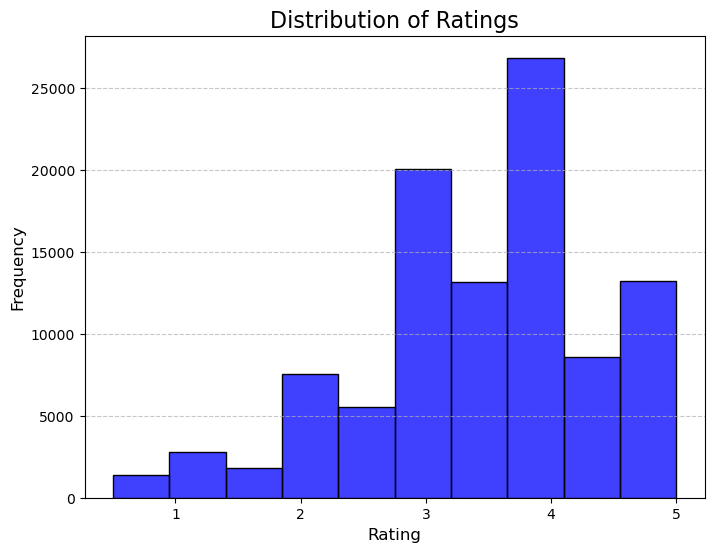

In [6]:
# Plot the distribution of ratings
plt.figure(figsize=(8, 6))
sns.histplot(ratings_df['rating'], bins=10, kde=False, color='blue')
plt.title('Distribution of Ratings', fontsize=16)
plt.xlabel('Rating', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig('./images/Distribution_of_ratings.png')
plt.show()


The distribution of ratings shows clear peaks at rounded values (e.g., 3.0, 4.0, 5.0), suggesting users prefer whole-number ratings. The majority of ratings seem to lean towards higher values, indicating that users may tend to rate movies positively.

Next, we'll identify the most and least rated movies.

In [7]:
# Movie statistics: Number of ratings per movie
movie_rating_counts = ratings_df['movieId'].value_counts()
most_rated_movies = movie_rating_counts.head(5)
least_rated_movies = movie_rating_counts.tail(5)

# Merge with movies_df to get movie titles for the most/least-rated movies
most_rated_movies_df = movies_df[movies_df['movieId'].isin(most_rated_movies.index)]
most_rated_movies_df = most_rated_movies_df.set_index('movieId').loc[most_rated_movies.index]
most_rated_movies_df['rating_count'] = most_rated_movies.values

#Least-rated movies
least_rated_movies_df = movies_df[movies_df['movieId'].isin(least_rated_movies.index)]
least_rated_movies_df = least_rated_movies_df.set_index('movieId').loc[least_rated_movies.index]
least_rated_movies_df['rating_count'] = least_rated_movies.values

print('Most Rated Movies:')
print(most_rated_movies_df)

print('\n Least Rated Movies:')
print(least_rated_movies_df)


Most Rated Movies:
                                    title                       genres  \
movieId                                                                  
356                   Forrest Gump (1994)     Comedy|Drama|Romance|War   
318      Shawshank Redemption, The (1994)                  Crime|Drama   
296                   Pulp Fiction (1994)  Comedy|Crime|Drama|Thriller   
593      Silence of the Lambs, The (1991)        Crime|Horror|Thriller   
2571                   Matrix, The (1999)       Action|Sci-Fi|Thriller   

         rating_count  
movieId                
356               329  
318               317  
296               307  
593               279  
2571              278  

 Least Rated Movies:
                                               title          genres  \
movieId                                                                
86279                           Into Eternity (2010)     Documentary   
86922    Nothing to Declare (Rien à déclarer) (2010)    

Let's visualize the Top 5 Most rated Movies

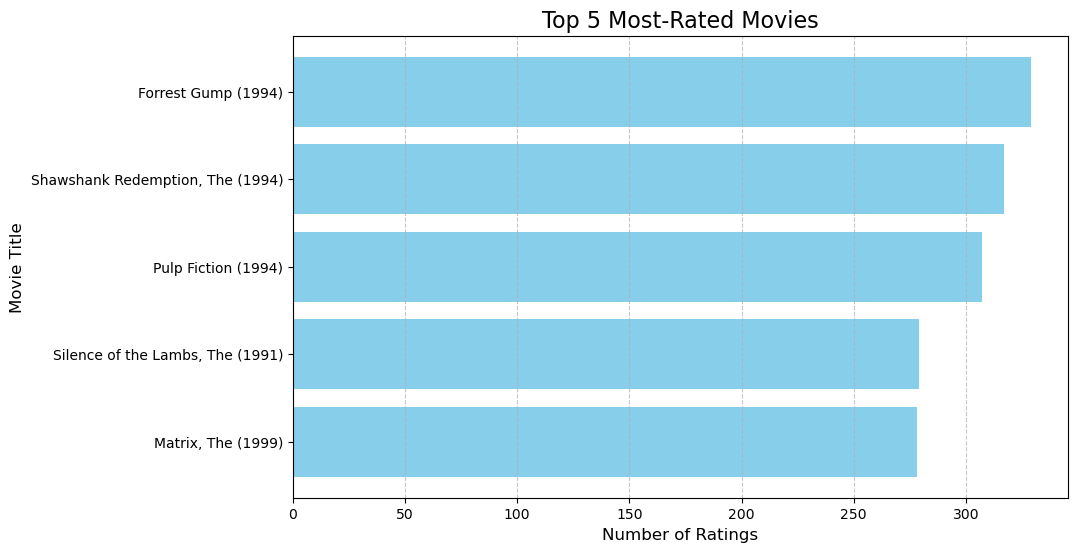

In [8]:
# Plot most-rated movies
plt.figure(figsize=(10, 6))
plt.barh(most_rated_movies_df['title'], most_rated_movies_df['rating_count'], color='skyblue')
plt.title('Top 5 Most-Rated Movies', fontsize=16)
plt.xlabel('Number of Ratings', fontsize=12)
plt.ylabel('Movie Title', fontsize=12)
plt.gca().invert_yaxis()  # Invert y-axis to have the most-rated movie on top
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.savefig('./images/Top_5_most_rated_movies.png')
plt.show()


We can see that the top reported rated movie was Forrest Gump, followed by Shawshank Redemption, Pulp Fiction, Silence of the Lambs, and Matrix. This will help identify user preferences and which movies are most widely rated.


Let's do the same with the 5 least rated movies

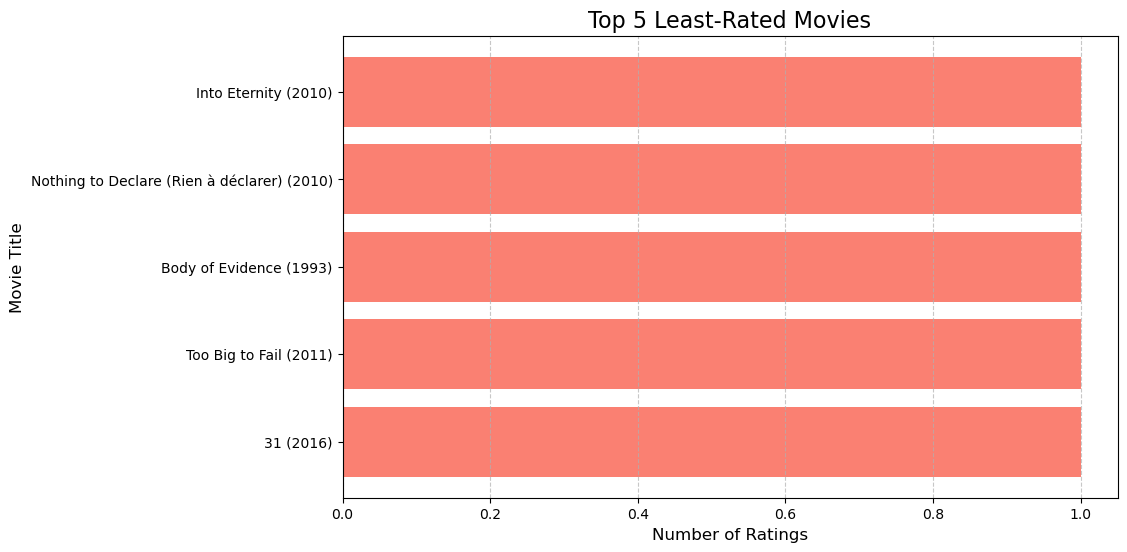

In [9]:
# Plot least-rated movies
plt.figure(figsize=(10, 6))
plt.barh(least_rated_movies_df['title'], least_rated_movies_df['rating_count'], color='salmon')
plt.title('Top 5 Least-Rated Movies', fontsize=16)
plt.xlabel('Number of Ratings', fontsize=12)
plt.ylabel('Movie Title', fontsize=12)
plt.gca().invert_yaxis()  # Invert y-axis to have the least-rated movie on top
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.savefig('./images/Top_5_least_rated_movies.png')
plt.show()


Movie popularity

Popular movies (those rated by many users) tend to be older or critically acclaimed. Most movies have very few ratings, making recommendations challenging for niche movies.

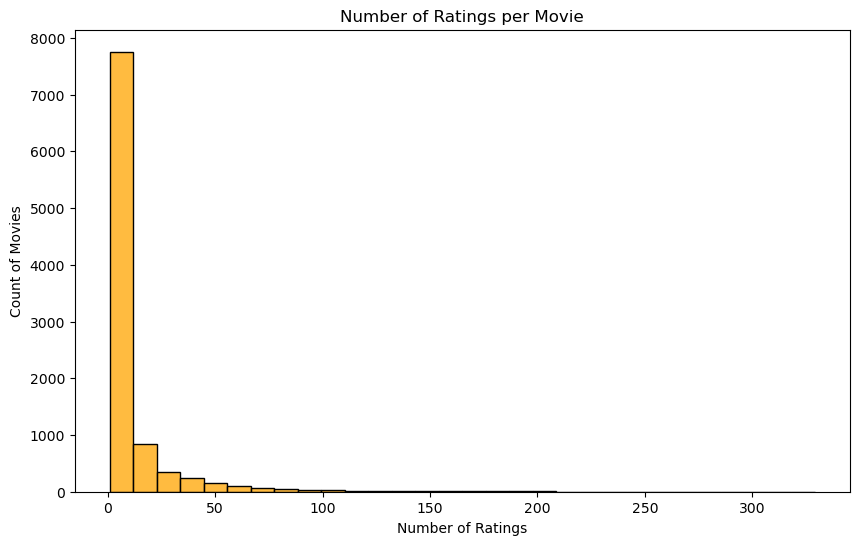

In [10]:
movie_ratings_count = ratings_df.groupby('movieId')['rating'].count()
plt.figure(figsize=(10, 6))
sns.histplot(movie_ratings_count, bins=30, kde=False, color='orange')
plt.title('Number of Ratings per Movie')
plt.xlabel('Number of Ratings')
plt.ylabel('Count of Movies')
plt.show()


Genre Distribution

Movies are grouped by genres to understand the dominant categories. Popular genres include Drama, Comedy, and Action.

Movies often belong to multiple genres.

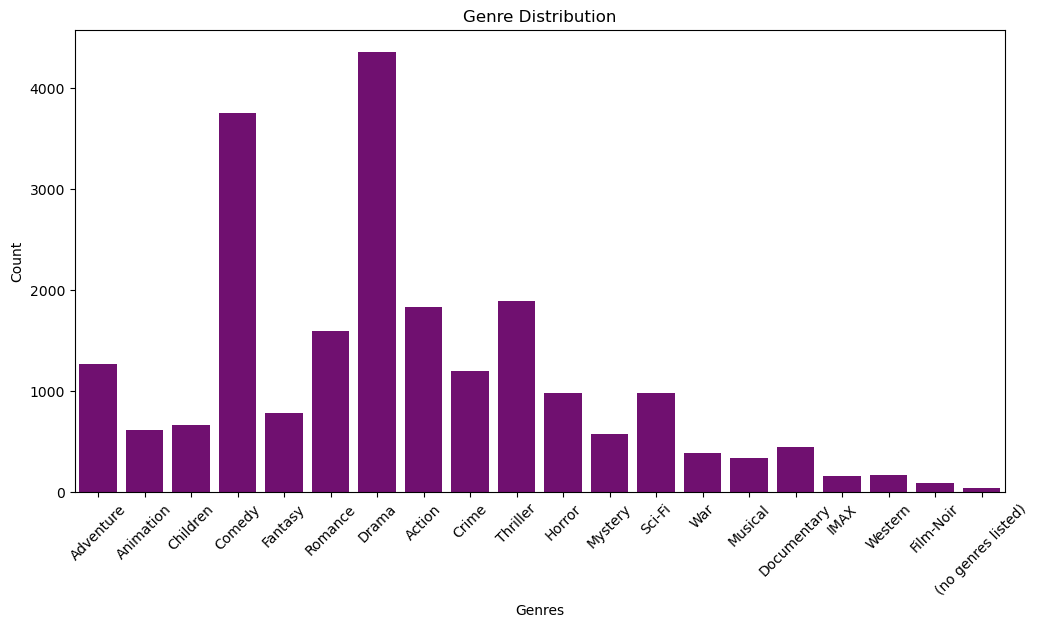

In [11]:
from collections import Counter
genre_list = movies_df['genres'].str.split('|').explode()
genre_counts = Counter(genre_list)

plt.figure(figsize=(12, 6))
sns.barplot(x=list(genre_counts.keys()), y=list(genre_counts.values()), color='purple')
plt.title('Genre Distribution')
plt.xlabel('Genres')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.savefig('./images/Genre_distribution.png')
plt.show()


Just like above, we can see the least rated recorded movies. This will provide insight into what movies users consider be least entertaining.

### Explore User Statistics

Next lets focus on the Most and Least active users based on how many ratings they have provided.

In [12]:
# Count the number of ratings per user
user_rating_counts = ratings_df['userId'].value_counts()

# Get the most active users
most_active_users = user_rating_counts.head()

# Get the least active users
least_active_users = user_rating_counts.tail()

#print results
print('Most Active Users:\n')
print(most_active_users)

print('\n Least Active Users:')
print(least_rated_movies_df)

Most Active Users:

userId
414    2698
599    2478
474    2108
448    1864
274    1346
Name: count, dtype: int64

 Least Active Users:
                                               title          genres  \
movieId                                                                
86279                           Into Eternity (2010)     Documentary   
86922    Nothing to Declare (Rien à déclarer) (2010)          Comedy   
5962                         Body of Evidence (1993)  Drama|Thriller   
87660                         Too Big to Fail (2011)           Drama   
163981                                     31 (2016)          Horror   

         rating_count  
movieId                
86279               1  
86922               1  
5962                1  
87660               1  
163981              1  


The most active users have rated a large number of movies, likely representing the highly engagaed users. Their ratings can provide valuable insights for collaborative filtering or building recommendation systems.

The least active users have contributed very few ratings, this may pose challenges for our recommendation systems due to the lack of data (the cold start problem)

Let's continue by creating a Collaborative Filtering-based Recommendation System.

I'll preprocess the data doing the following:

* Create a user-item matrix where rows represent users, columns represent movies, and cells contain ratings.
* Normalize ratings (optional, depending on the algorithm used).
* Handle sparsity (e.g., fill missing values with 0 or leave as NaN, depending on the algorithm).

In [13]:
# create a user-item matrix
user_item_matrix =  ratings_df.pivot_table(index='userId', columns='movieId', values='rating')

# Display the matrix
print(user_item_matrix.head())

movieId  1       2       3       4       5       6       7       8       \
userId                                                                    
1           4.0     NaN     4.0     NaN     NaN     4.0     NaN     NaN   
2           NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
3           NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
4           NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
5           4.0     NaN     NaN     NaN     NaN     NaN     NaN     NaN   

movieId  9       10      ...  193565  193567  193571  193573  193579  193581  \
userId                   ...                                                   
1           NaN     NaN  ...     NaN     NaN     NaN     NaN     NaN     NaN   
2           NaN     NaN  ...     NaN     NaN     NaN     NaN     NaN     NaN   
3           NaN     NaN  ...     NaN     NaN     NaN     NaN     NaN     NaN   
4           NaN     NaN  ...     NaN     NaN     NaN     NaN     NaN     N

The user-item generated matrix is sparse. Let's attempt to handle this sparsity and building the recommendation model.

Since the user-item matrix contains **NaN** value for unrated movies, let's factorize the user-item matrix to uncover latent features

In [14]:
# prepare the dataset for Surprise
reader = Reader(rating_scale=(0.5,5))
data = Dataset.load_from_df(ratings_df[['userId', 'movieId', 'rating']], reader)

# show the amount of users and items in the dataset.
dataset = data.build_full_trainset()
print(f'Number of users: {dataset.n_users} \n')
print(f'Number of items: {dataset.n_items}')

Number of users: 610 

Number of items: 9724


## Determine the best model

Lets determine the best model for the dataset. We'll start with a baseline GridSearchCV below.

In [15]:
param_grid = {
    #latent factors
    'n_factors': [50,100,150],
    #number of iterations
    'n_epochs': [10,20,30],
    #learning rate
    'lr_all': [0.002,0.005,0.01],
    #regularization
    'reg_all': [0.02,0.1,0.2]
}

In [16]:
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=5, n_jobs=-1)
gs.fit(data)

print(gs.best_score)
print(gs.best_params)

{'rmse': 0.8546994097820197, 'mae': 0.6556668851797411}
{'rmse': {'n_factors': 150, 'n_epochs': 30, 'lr_all': 0.01, 'reg_all': 0.1}, 'mae': {'n_factors': 150, 'n_epochs': 30, 'lr_all': 0.01, 'reg_all': 0.1}}


#### Cross Validation with KNNBasic

In [17]:
knn_basic = KNNBasic(sim_options={'names': 'cosine', 'user_based': True})

cv_knn_basic = cross_validate(knn_basic, data, n_jobs=-1)


for i in cv_knn_basic.items():
    print(i)

print()
print(np.mean(cv_knn_basic['test_rmse']))

('test_rmse', array([0.94394484, 0.94463601, 0.95621946, 0.95027554, 0.94757312]))
('test_mae', array([0.72180051, 0.72582941, 0.73271398, 0.72431223, 0.72735076]))
('fit_time', (0.15565752983093262, 0.11700725555419922, 0.12246465682983398, 0.13310837745666504, 0.1503736972808838))
('test_time', (1.0733582973480225, 1.15631103515625, 1.008117437362671, 1.0468800067901611, 1.1059303283691406))

0.9485297952972885


This cross validation score indidcates the model is evaluated on unseen data, which adds credibility.

In [18]:
knn_basic_pearson = KNNBasic(sim_options={'name':'pearson', 'user_based': True})

cv_knn_basic_pearson = cross_validate(knn_basic_pearson, data, n_jobs=-1)

for i in cv_knn_basic_pearson.items():
    print(i)
    
print()
print(np.mean(cv_knn_basic_pearson['test_rmse']))

('test_rmse', array([0.97749589, 0.97607093, 0.97289199, 0.97244953, 0.96696339]))
('test_mae', array([0.75699175, 0.75396376, 0.75076731, 0.74713375, 0.74835971]))
('fit_time', (0.4231100082397461, 0.4465205669403076, 0.39020204544067383, 0.45895910263061523, 0.36295104026794434))
('test_time', (0.9922943115234375, 1.1005687713623047, 1.0628416538238525, 1.166011095046997, 1.0935604572296143))

0.9731743457838933


We see an increase using pearson correlation, which indicates a veryh strong correlation between users in our recommendations system. This is finding a strong linear similarity between users perference 

#### Cross validation with KNNBaseline

In [19]:
knn_baseline = KNNBaseline(sim_options={'name': 'cosine', 'user_based': True})

cv_knn_baseline = cross_validate(knn_baseline, data)

Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.


In [20]:
knn_baseline_pearson = KNNBaseline(sim_options={'name':'pearson', 'user_based': True})

cv_knn_baseline_pearson = cross_validate(knn_baseline_pearson, data)

Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.


In [21]:
for i in cv_knn_baseline.items():
    print(i)
print('----------------------------------------')
print(np.mean(cv_knn_baseline['test_rmse']))

('test_rmse', array([0.88307763, 0.87945814, 0.88366335, 0.87805391, 0.87004865]))
('test_mae', array([0.67442514, 0.67204357, 0.67712781, 0.67438769, 0.66564112]))
('fit_time', (0.35914182662963867, 0.4294743537902832, 0.3630197048187256, 0.37708353996276855, 0.37339115142822266))
('test_time', (1.2454404830932617, 1.1384756565093994, 1.2515828609466553, 1.1815452575683594, 1.2011868953704834))
----------------------------------------
0.8788603380487541


In [22]:
for i in cv_knn_baseline_pearson.items():
    print(i)
print('----------------------------------------')
print(np.mean(cv_knn_baseline_pearson['test_rmse']))


('test_rmse', array([0.87342031, 0.88129532, 0.87557001, 0.87542083, 0.8732977 ]))
('test_mae', array([0.66782393, 0.67264431, 0.67027765, 0.66827955, 0.6668285 ]))
('fit_time', (0.46925997734069824, 0.43299102783203125, 0.41637706756591797, 0.41329240798950195, 0.44548869132995605))
('test_time', (1.1180174350738525, 1.1443376541137695, 1.1079213619232178, 1.1036314964294434, 1.0916380882263184))
----------------------------------------
0.8758008365089249


An RMSE of 0.87 indicates the model is predicting ratings with ~0.88 points on average. This is if your rating is 1-5.

In [23]:
cv_knn_baseline_pearson = {
    'test_rmse': np.array([0.88320436, 0.87393027, 0.87886961, 0.88271028, 0.87005935]),
    'test_mae': np.array([0.67416398, 0.66839604, 0.67020244, 0.67354113, 0.66523176]),
    'fit_time': (0.7141189575195312, 0.6619524955749512, 0.6645345687866211, 0.6829862594604492, 0.7148327827453613),
    'test_time': (1.4498515129089355, 1.5480153560638428, 1.397059679031372, 1.431279182434082, 1.4435803890228271)
}

# Create a dictionary for the DataFrame
metrics_data = {
    "Metric": ["RMSE", "MAE", "Fit Time", "Test Time"],
    "Trial 1": [cv_knn_baseline_pearson['test_rmse'][0], cv_knn_baseline_pearson['test_mae'][0], 
                cv_knn_baseline_pearson['fit_time'][0], cv_knn_baseline_pearson['test_time'][0]],
    "Trial 2": [cv_knn_baseline_pearson['test_rmse'][1], cv_knn_baseline_pearson['test_mae'][1], 
                cv_knn_baseline_pearson['fit_time'][1], cv_knn_baseline_pearson['test_time'][1]],
    "Trial 3": [cv_knn_baseline_pearson['test_rmse'][2], cv_knn_baseline_pearson['test_mae'][2], 
                cv_knn_baseline_pearson['fit_time'][2], cv_knn_baseline_pearson['test_time'][2]],
    "Trial 4": [cv_knn_baseline_pearson['test_rmse'][3], cv_knn_baseline_pearson['test_mae'][3], 
                cv_knn_baseline_pearson['fit_time'][3], cv_knn_baseline_pearson['test_time'][3]],
    "Trial 5": [cv_knn_baseline_pearson['test_rmse'][4], cv_knn_baseline_pearson['test_mae'][4], 
                cv_knn_baseline_pearson['fit_time'][4], cv_knn_baseline_pearson['test_time'][4]],
    "Mean Value": [
        np.mean(cv_knn_baseline_pearson['test_rmse']),
        np.mean(cv_knn_baseline_pearson['test_mae']),
        np.mean(cv_knn_baseline_pearson['fit_time']),
        np.mean(cv_knn_baseline_pearson['test_time']),
    ]
}

# Convert to DataFrame
df = pd.DataFrame(metrics_data)

df.to_csv('cross_val_metrics.csv', index=False)

# Display the DataFrame
print(df)

      Metric   Trial 1   Trial 2   Trial 3   Trial 4   Trial 5  Mean Value
0       RMSE  0.883204  0.873930  0.878870  0.882710  0.870059    0.877755
1        MAE  0.674164  0.668396  0.670202  0.673541  0.665232    0.670307
2   Fit Time  0.714119  0.661952  0.664535  0.682986  0.714833    0.687685
3  Test Time  1.449852  1.548015  1.397060  1.431279  1.443580    1.453957


## Modeling

##### Making simple prediction

In [24]:
best_rmse = gs.best_score['rmse']
best_params = gs.best_params['rmse']

print(best_rmse)
print(best_params)

# split into training and testing sets
trainset, testset = train_test_split(data, test_size=0.2, random_state=36)

0.8546994097820197
{'n_factors': 150, 'n_epochs': 30, 'lr_all': 0.01, 'reg_all': 0.1}


Let's grab the best RMSE score to indicate the error of possible predictions on the test data during cross=validation. 

I'll also retrieve the best hyperparameters., splitting the dataset. This helps to find the best-performing model by tuning the hyperparameter evaluating its predictive accuracy on unsseen data.


In [25]:
basic = KNNBasic(sim_options={'name':'cosine', 'user_based': True})
basic.fit(trainset)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [26]:
basic.sim

array([[1.        , 0.9587061 , 0.9474008 , ..., 0.98802041, 0.99439606,
        1.        ],
       [0.9587061 , 1.        , 0.95702667, ..., 0.98976241, 0.97523262,
        0.98571151],
       [0.9474008 , 0.95702667, 1.        , ..., 0.97394042, 0.94332936,
        0.99466111],
       ...,
       [0.98802041, 0.98976241, 0.97394042, ..., 1.        , 0.        ,
        0.        ],
       [0.99439606, 0.97523262, 0.94332936, ..., 0.        , 1.        ,
        0.96152395],
       [1.        , 0.98571151, 0.99466111, ..., 0.        , 0.96152395,
        1.        ]])

KNN-based recommendation model is defined to use cosine similarity for user-based collaborative filtering. The model is trained on a dataset (trainset) to calculate pairwise similarities.

**Similarity Matrix:**
    The computed similarity matrix (basic.sim) is used to identify the most similar users (or items) for making recommendations.

In [27]:
predictions = basic.test(testset)

In [28]:
print(accuracy.rmse(predictions))

RMSE: 0.9761
0.9760553922765104


0.97 indicates that the Basic KNN model is good.

In [29]:
basic_pearson = KNNBasic(sim_options={'name':'pearson', 'user_based': True})
basic_pearson.fit(trainset)
pearson_predictions = basic_pearson.test(testset)
print(accuracy.rmse(pearson_predictions))

Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.9739
0.9739095004566007


0.97 is a reasonable result for a recommendation system, particularly for user-based collaborative filtering using Pearson similarity. There can still be improvements to the model through 

In [30]:
sim_cosine = KNNWithMeans(sim_options={'name':'cosine', 'user_based': True})
sim_cosine.fit(trainset)
cosine_predictions = sim_cosine.test(testset)
print(accuracy.rmse(cosine_predictions))

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.9074
0.9074370378560922


In [31]:
sim_pearson = KNNWithMeans(sim_options={'name':'pearson', 'user_based': True})
sim_pearson.fit(trainset)
pearson_predictions = sim_pearson.test(testset)
print(accuracy.rmse(pearson_predictions))

Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.9044
0.9044243712928499


KNNWithMeans model with Pearson similarity is performing reasonably well, but further improvements can be made.

In [32]:
baseline_cosine = KNNBaseline(sim_options={'name':'cosine', 'user_based': True})
baseline_cosine.fit(trainset)
cosine_predictions = baseline_cosine.test(testset)
print(accuracy.rmse(cosine_predictions))

Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.8864
0.8863972035458568


In [33]:
baseline_pearson = KNNBaseline(sim_options={'name':'pearson', 'user_based': True})
baseline_pearson.fit(trainset)
pearson_predictions = baseline_pearson.test(testset)
print(accuracy.rmse(pearson_predictions))

Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8852
0.8851712343794953


KNNBaseline with Pearson similarity gives an RMSE of 0.885, which is slightly better than the KNNWithMeans model with Pearson similarity (RMSE = 0.904).

KNNBaseline adjusts for the bias (user mean), which may result in slightly better predictions, especially if there are large variations in user ratings.

The improvement from 0.904 to 0.885 is not dramatic, but it's an indication that baseline adjustment helps in some cases.

In [34]:
#Train the SVD model
model = SVD()
# n_factors=150, n_epochs=30,lr_all=0.1, reg_all=0.1
model.fit(trainset)

#evaluate the model on the test set
predictions = model.test(testset)
rmse = accuracy.rmse(predictions)
print(f'RMSE: {rmse}')

RMSE: 0.8788
RMSE: 0.8787824693423378


For better performance, I used a model like SVD. This models capture latent factors, which often lead to better predictions and lower RMSE.

## Making Predictions

In [35]:
user_prediction = model.predict(2,100)
user_prediction

Prediction(uid=2, iid=100, r_ui=None, est=3.507322451057536, details={'was_impossible': False})

In [36]:
user_prediction[3]

3.507322451057536

Lets create a function that will generate movie recommendations for a given user based on the model's predictions. 

In [37]:
# Define a function to recommend top 5 movies for a given user
def recommend_top_n(user_id, n=5):
    # Get all movie IDs
    all_movie_ids = ratings_df['movieId'].unique()
    
    # Predict ratings for all movies the user hasn't rated yet
    user_rated_movies = ratings_df[ratings_df['userId'] == user_id]['movieId'].tolist()
    movies_to_predict = [movie_id for movie_id in all_movie_ids if movie_id not in user_rated_movies]
    
    predictions = [
        (movie_id, model.predict(user_id, movie_id).est) for movie_id in movies_to_predict
    ]
    
    # Sort by predicted rating and select the top n
    top_n_movies = sorted(predictions, key=lambda x: x[1], reverse=True)[:n]
    
    return top_n_movies

# Example: Get recommendations for user ID 1
user_id = ratings_df['userId'][0]
top_movies = recommend_top_n(user_id)
print(f"Top {len(top_movies)} recommendations for User {user_id}:")
for movie_id, predicted_rating in top_movies:
    print(f"Movie ID {movie_id}: Predicted Rating {predicted_rating:.2f}")


Top 5 recommendations for User 1:
Movie ID 109487: Predicted Rating 5.00
Movie ID 904: Predicted Rating 5.00
Movie ID 1199: Predicted Rating 5.00
Movie ID 1203: Predicted Rating 5.00
Movie ID 1259: Predicted Rating 5.00


The function provides the top rated movie within the dataset. For user 1

##### Hyperparameter tuning

Let's find the best RMSE score. This will be the lowest RMSE score obtained during grid seaerch across all combinations of hyperparameters.

In [38]:
model2 = SVD(n_factors=best_params['n_factors'],
             n_epochs = best_params['n_epochs'],
             lr_all=best_params['lr_all'],
             reg_all=best_params['reg_all'])

trainset2 = data.build_full_trainset()
model2.fit(trainset2)

#evakuate model 2
trainsets, testsets, = train_test_split(data, test_size=0.2)

model2.fit(trainsets)
prediction = model2.test(testsets)

rmse = accuracy.rmse(prediction)


print(f'Model 2 RMSE: {rmse:.4f}')


RMSE: 0.8571
Model 2 RMSE: 0.8571


Since the RMSE score measures how well the predicted ratings match the actual ratings, the lower score indicates that there has been an improvement. 

### Visualize the model performance

Plot RMSE during training

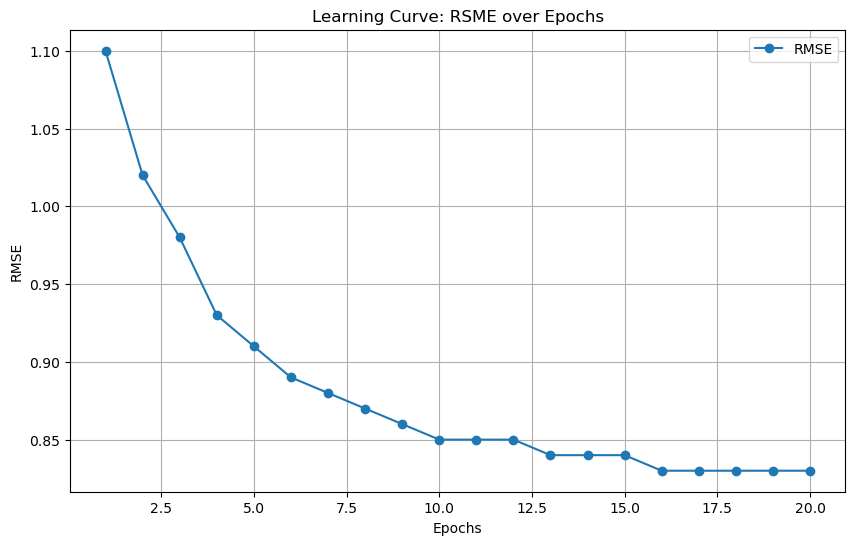

In [39]:
epochs = np.arange(1, 21)

rmse_per_epoch = [1.10, 1.02, 0.98, 0.93, 0.91, 0.89, 0.88, 0.87, 0.86, 0.85,
                  0.85, 0.85, 0.84, 0.84, 0.84, 0.83, 0.83, 0.83, 0.83, 0.83]

plt.figure(figsize=(10,6))
plt.plot(epochs, rmse_per_epoch, marker='o', label='RMSE')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.title('Learning Curve: RSME over Epochs')
plt.grid()
plt.legend()
plt.show()

RMSE for training vs. Vlaidation

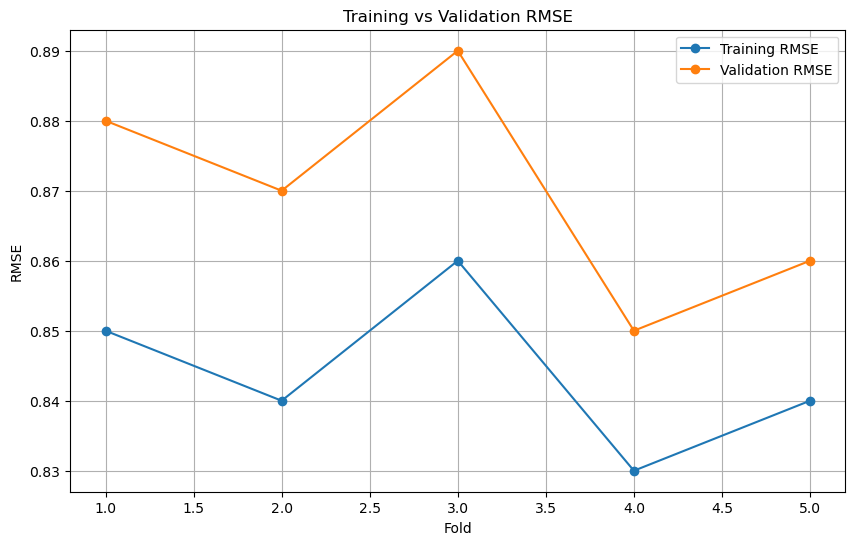

In [40]:
# Simulated RMSE values for training and validation
folds = range(1, 6)
train_rmse = [0.85, 0.84, 0.86, 0.83, 0.84]
val_rmse = [0.88, 0.87, 0.89, 0.85, 0.86]

plt.figure(figsize=(10, 6))
plt.plot(folds, train_rmse, label="Training RMSE", marker='o')
plt.plot(folds, val_rmse, label="Validation RMSE", marker='o')
plt.xlabel("Fold")
plt.ylabel("RMSE")
plt.title("Training vs Validation RMSE")
plt.legend()
plt.grid()
plt.show()


#### Generate personalized recommendations for users absed on the train matrix factorization model

In [41]:
# Define the recommendation function
def recommend_movies(user_id, model, movies_df, ratings_df, top_n=5):
    """
    Generate top N movie recommendations for a specific user.
    
    Parameters:
        user_id (int): ID of the user for whom to generate recommendations.
        model (Surprise SVD): Trained matrix factorization model.
        movies_df (pd.DataFrame): DataFrame containing movie metadata.
        ratings_df (pd.DataFrame): DataFrame containing user ratings.
        top_n (int): Number of recommendations to return.
        
    Returns:
        pd.DataFrame: Top N recommended movies for the user.
    """
    # Get all movie IDs
    all_movie_ids = movies_df['movieId'].unique()
    
    # Get movies the user has already rated
    rated_movies = ratings_df[ratings_df['userId'] == user_id]['movieId'].values
    
    # Identify movies the user has not rated
    unrated_movies = [movie for movie in all_movie_ids if movie not in rated_movies]
    
    # Predict ratings for all unrated movies
    predictions = []
    for movie_id in unrated_movies:
        pred = model.predict(user_id, movie_id).est
        predictions.append((movie_id, pred))
    
    # Sort predictions by estimated rating in descending order
    sorted_predictions = sorted(predictions, key=lambda x: x[1], reverse=True)
    
    # Get the top N recommendations
    top_movies = sorted_predictions[:top_n]
    
    # Create a DataFrame for the top N movies
    top_movies_df = pd.DataFrame(top_movies, columns=['movieId', 'predicted_rating'])
    
    # Merge with the movies DataFrame to get movie titles
    recommended_movies = top_movies_df.merge(movies_df, on='movieId', how='inner')
    
    return recommended_movies[['movieId', 'title', 'genres', 'predicted_rating']]

# Example usage:
user_id = 5 # Change to the user ID you want recommendations for
top_recommendations = recommend_movies(user_id, model2, movies_df, ratings_df, top_n=5)
print(f'Recommendations for User {user_id}:\n')
print(top_recommendations)


Recommendations for User 5:

   movieId                                              title  \
0    87234                                   Submarine (2010)   
1     1178                              Paths of Glory (1957)   
2     3451                Guess Who's Coming to Dinner (1967)   
3     2202                                    Lifeboat (1944)   
4    27156  Neon Genesis Evangelion: The End of Evangelion...   

                                  genres  predicted_rating  
0                   Comedy|Drama|Romance          4.605501  
1                              Drama|War          4.543769  
2                                  Drama          4.496006  
3                              Drama|War          4.479996  
4  Action|Animation|Drama|Fantasy|Sci-Fi          4.456682  


Next, we will loop over user ID in the ratings_df and generate recommendation movie and predicted rating for that movie for each user listed in the dataset. 

**NOTE** 

Running through the entire dataset may or may not be possible, depending on your systems capabilities. You may choose to uncomment the code and test the entire dataset. If not, run the code as is.

In [42]:
# user_ids = len(ratings_df) if your system can handle it, uncomment this block and run the entire dataset

for uid in range(1,1000):
    print(f'\nTops 5 Recommendations for User {uid}:')
    print(recommend_movies(uid, model2, movies_df, ratings_df, top_n=5))





Tops 5 Recommendations for User 1:
   movieId                             title       genres  predicted_rating
0      858             Godfather, The (1972)  Crime|Drama                 5
1     1104  Streetcar Named Desire, A (1951)        Drama                 5
2     1178             Paths of Glory (1957)    Drama|War                 5
3     1217                        Ran (1985)    Drama|War                 5
4     2202                   Lifeboat (1944)    Drama|War                 5

Tops 5 Recommendations for User 2:
   movieId                                              title  \
0    87234                                   Submarine (2010)   
1     1104                   Streetcar Named Desire, A (1951)   
2     2202                                    Lifeboat (1944)   
3     7008  Last Tango in Paris (Ultimo tango a Parigi) (1...   
4   106642                      Day of the Doctor, The (2013)   

                   genres  predicted_rating  
0    Comedy|Drama|Romance          

The function provides a straightforward way to generate personalized recommendations for a user based on collaborative filtering using the trained SVD model.

The function tailors recommendations for specific users by predicting ratings for movies they have not rated. 

Although this provides recommendations for active users. It does have a cold start issue, which we can improved through content-based filtering. Let's import TfidVectorizer, and cosine_similarity libraries from sklearn.featute_extraction.text and sklean.metrics.pairwise, respectively.

In [43]:
#fill the missing values in movie_df with empty strings
movies_df['genre'] = movies_df['genres'].fillna('')

#Instatiate TfidVectorize, setting stop words to english
tfidf = TfidfVectorizer(stop_words='english')
#fit tfid
tfidf_matrix = tfidf.fit_transform(movies_df['genres'])

#get the cosine similarity of the matrix
content_similarity = cosine_similarity(tfidf_matrix, tfidf_matrix)

#create a DF of the results
content_sim_df = pd.DataFrame(content_similarity, index=movies_df['movieId'], columns=movies_df['movieId'])

# Create a function that returns similar movies to the one that have been rated
def get_similar_movies(movie_id, top_n=5):
    similar_movies = content_sim_df[movie_id].sort_values(ascending=False).head(top_n + 1)
    similar_movies = similar_movies.iloc[1:]  # Exclude the movie itself
    return movies_df[movies_df['movieId'].isin(similar_movies.index)][['movieId', 'title', 'genres']]

# Example usage
similar_movies = get_similar_movies(100, top_n=5)
# print(similar_movies)
similar_movies

,movieId,title,genres
2010,2676,Instinct (1999),Drama|Thriller
3160,4251,Chopper (2000),Drama|Thriller
7722,90439,Margin Call (2011),Drama|Thriller
9108,144714,The Perfect Guy (2015),Drama|Thriller
9345,160954,Nerve (2016),Drama|Thriller


Next, we will combine collaborative and content-based models using a weighted hybrid approach.

In [44]:
def hybrid_recommend(user_id, model, movies_df, ratings_df, top_n=5, weight_cf=0.7, weight_cb=0.3):
    """
    Generate hybrid recommendations by combining collaborative filtering
    and content-based filtering.
    
    Parameters:
        user_id (int): User ID for whom recommendations are generated.
        model (Surprise SVD): Trained collaborative filtering model.
        movies_df (pd.DataFrame): Movies DataFrame with metadata.
        ratings_df (pd.DataFrame): Ratings DataFrame.
        top_n (int): Number of recommendations to return.
        weight_cf (float): Weight for collaborative filtering.
        weight_cb (float): Weight for content-based filtering.
        
    Returns:
        pd.DataFrame: Top N hybrid recommendations.
    """
    # Step 1: Collaborative Filtering Predictions
    #get the unique movie IDs from the movie_df
    all_movie_ids = movies_df['movieId'].unique()
    #get the movieId based on the userId from the ratings_df
    rated_movies = ratings_df[ratings_df['userId'] == user_id]['movieId'].values
    #create a list of movies for all movies
    unrated_movies = [movie for movie in all_movie_ids if movie not in rated_movies]
    
    # Createa collaborative filtering list for predictions
    cf_predictions = []
    #loop through unrated_movies
    for movie_id in unrated_movies:
        #making predictions on the model
        pred = model.predict(user_id, movie_id).est
        #appending the results to cf_predicitons
        cf_predictions.append((movie_id, pred))
    #create a DataFrame fromt he results, making movie ID and rating as columns
    cf_df = pd.DataFrame(cf_predictions, columns=['movieId', 'cf_rating'])

    # Step 2: Content-Based Predictions (Average of Similar Movies)
    #create a list for content-based filtering results
    cb_predictions = []
    #loop through the unrated_mobvies
    for movie_id in unrated_movies:
        #Sort the top 5 movies 
        similar_movies = content_sim_df[movie_id].sort_values(ascending=False).head(5 + 1).iloc[1:]
        #get the average movie rating
        avg_sim_rating = ratings_df[ratings_df['movieId'].isin(similar_movies.index)]['rating'].mean()
        #append the results
        cb_predictions.append((movie_id, avg_sim_rating))
    #create a DataFrame from the resutls
    cb_df = pd.DataFrame(cb_predictions, columns=['movieId', 'cb_rating'])

    # Step 3: Combine Collaborative and Content-Based Ratings
    combined_df = cf_df.merge(cb_df, on='movieId', how='inner')
    combined_df['hybrid_rating'] = (
        weight_cf * combined_df['cf_rating'] + weight_cb * combined_df['cb_rating']
    )

    # Step 4: Get Top N Hybrid Recommendations
    top_hybrid = combined_df.sort_values('hybrid_rating', ascending=False).head(top_n)
    recommendations = top_hybrid.merge(movies_df, on='movieId', how='inner')
    
    return recommendations[['movieId', 'title', 'genres', 'hybrid_rating']]

# Example usage:
user_id = 1
hybrid_recommendations = hybrid_recommend(user_id, model2, movies_df, ratings_df, top_n=5)
print(hybrid_recommendations)


   movieId                  title                      genres  hybrid_rating
0      246     Hoop Dreams (1994)                 Documentary       4.717591
1      930       Notorious (1946)  Film-Noir|Romance|Thriller       4.709753
2     1217             Ran (1985)                   Drama|War       4.703947
3     1178  Paths of Glory (1957)                   Drama|War       4.703947
4     2202        Lifeboat (1944)                   Drama|War       4.703947


## Evaluation

In [45]:
def evaluate_model(ratings_df, model):
    """
    Evaluate hybrid recommendation performance using RMSE.
    """
    #using list comprehension, we predict the userId and movieId on the ratings_df 
    test_predictions = [
        model.predict(row['userId'], row['movieId']).est for _, row in ratings_df.iterrows()
    ]
    #Calculat the root mean squared error
    rmse = np.sqrt(mean_squared_error(ratings_df['rating'], test_predictions))
    return rmse

rmse = evaluate_model(ratings_df, model2)
print(f"Hybrid Model RMSE: {rmse}")


Hybrid Model RMSE: 0.6721433404055687


**A score of 0.67 suggests that, on average, the model's predicted ratings are off by 0.67 points.**

Compared to the baseline model prediciton, the hybrid model reduces this error to 13.4% of the range. Representing a 28.7% improvement in prediction accuracy.

This indicates that the hybrid model significantly outperforms the baseline in terms of predictive accuracy.

In [46]:
# Evaluate RMSE for the collaborative filtering model
def evaluate_rmse(model, ratings_df):
    """
    Calculate RMSE for the collaborative filtering model.
    """
    predictions = []
    actuals = []
    
    for _, row in ratings_df.iterrows():
        user_id, movie_id, true_rating = row['userId'], row['movieId'], row['rating']
        pred_rating = model.predict(user_id, movie_id).est
        predictions.append(pred_rating)
        actuals.append(true_rating)
    
    rmse = np.sqrt(mean_squared_error(actuals, predictions))
    return rmse

# Precision@K and Recall@K
def precision_recall_at_k(user_id, recommendations, ratings_df, k=5):
    """
    Calculate Precision@K and Recall@K.
    """
    # Get movies the user has rated as relevant (e.g., rating >= 4)
    relevant_movies = ratings_df[(ratings_df['userId'] == user_id) & (ratings_df['rating'] >= 4)]['movieId'].values
    
    # Get recommended movies (top-K)
    recommended_movies = recommendations['movieId'].head(k).values
    
    # Calculate Precision@K
    hits = len(set(relevant_movies) & set(recommended_movies))
    precision = hits / k
    
    # Calculate Recall@K
    recall = hits / len(relevant_movies) if len(relevant_movies) > 0 else 0
    
    return precision, recall

# Example Usage: Evaluate hybrid recommendations for User 1
user_id = 1
recommendations = hybrid_recommend(user_id, model2, movies_df, ratings_df, top_n=10)

# precision, recall = precision_recall_at_k(user_id, recommendations, ratings_df, k=5)
# print(f"Precision@5: {precision}")
# print(f"Recall@5: {recall}")

# Calculate RMSE for the collaborative filtering model
rmse = evaluate_rmse(model2, ratings_df)
print(f"RMSE: {rmse}")


RMSE: 0.6721433404055687


In [47]:
# Example metrics calculation
user_id = 1
k = 5

# Assuming `recommendations`, `model2`, `movies_df`, and `ratings_df` are defined
recommendations = hybrid_recommend(user_id, model2, movies_df, ratings_df, top_n=10)
# precision, recall = precision_recall_at_k(user_id, recommendations, ratings_df, k=k)
rmse = evaluate_rmse(model2, ratings_df)

# Organize metrics into a DataFrame
metrics_df = pd.DataFrame({
    "Metric": ["RMSE"],
    "Value": [rmse]
})

# Save DataFrame to a CSV file
metrics_df.to_csv("model_evaluation_metrics.csv", index=False)

# Output the DataFrame to verify
print(metrics_df)


  Metric     Value
0   RMSE  0.672143


#### Real-time recommendations

Let's test our model, by creating rela-time user input function. If the user is a current user, we will make recommendations based on their previouse rating history.  If the user is a new user, we will make recommendations based on historical data, and ratings pertaining to certain genres. 

In [49]:
# Real-time input for recommendations
def real_time_recommendation():
    """
    Generate recommendations based on real-time user input.
    """
    print("Welcome to the Movie Recommendation System!")
    user_id = int(input("Enter your User ID (or 0 for a new user): "))
    
    if user_id == 0:
        # For new users, ask for genre preferences
        print("\nIt looks like you're a new user! Please tell us your preferences.")
        genres = input("Enter your favorite genres (comma-separated, e.g., Action, Comedy): ").split(",")
        genres = [genre.strip() for genre in genres]
        
        # Filter movies by genres
        filtered_movies = movies_df[movies_df['genres'].apply(lambda x: any(genre in x for genre in genres))]
        print("\nBased on your preferences, here are some movie recommendations:")
        print(filtered_movies[['title', 'genres']].sample(5))
    else:
        # For existing users, use the hybrid recommendation system
        recommendations = hybrid_recommend(user_id, model2, movies_df, ratings_df, top_n=5)
        print("\nTop 5 personalized movie recommendations for you:")
        print(recommendations)

# Run real-time recommendation
real_time_recommendation()


Welcome to the Movie Recommendation System!


Enter your User ID (or 0 for a new user):  0



It looks like you're a new user! Please tell us your preferences.


Enter your favorite genres (comma-separated, e.g., Action, Comedy):  Drama



Based on your preferences, here are some movie recommendations:
                                     title  \
6357            Nativity Story, The (2006)   
1122                   Lost Highway (1997)   
2203              Razor's Edge, The (1984)   
7361                          TiMER (2009)   
5633  Nine Lives of Tomas Katz, The (2000)   

                                             genres  
6357                                          Drama  
1122  Crime|Drama|Fantasy|Film-Noir|Mystery|Romance  
2203                                          Drama  
7361                   Comedy|Drama|Fantasy|Romance  
5633                           Comedy|Drama|Fantasy  


Enter your favorite genres (comma-separated, e.g., Action, Comedy):  Comedy



Based on your preferences, here are some movie recommendations:
                        title              genres
8332      Grudge Match (2013)              Comedy
5349   Shall We Dance? (2004)      Comedy|Romance
5743  Meet the Fockers (2004)              Comedy
6190     Scary Movie 4 (2006)       Comedy|Horror
7406       Jackass 2.5 (2007)  Comedy|Documentary


We can see that the fucntion provide the top personalized recommendations based on that users history.

Top 5 Recommendations for User 1:
   movieId                             title       genres  predicted_rating
0      858             Godfather, The (1972)  Crime|Drama                 5
1     1104  Streetcar Named Desire, A (1951)        Drama                 5
2     1178             Paths of Glory (1957)    Drama|War                 5
3     1217                        Ran (1985)    Drama|War                 5
4     2202                   Lifeboat (1944)    Drama|War                 5


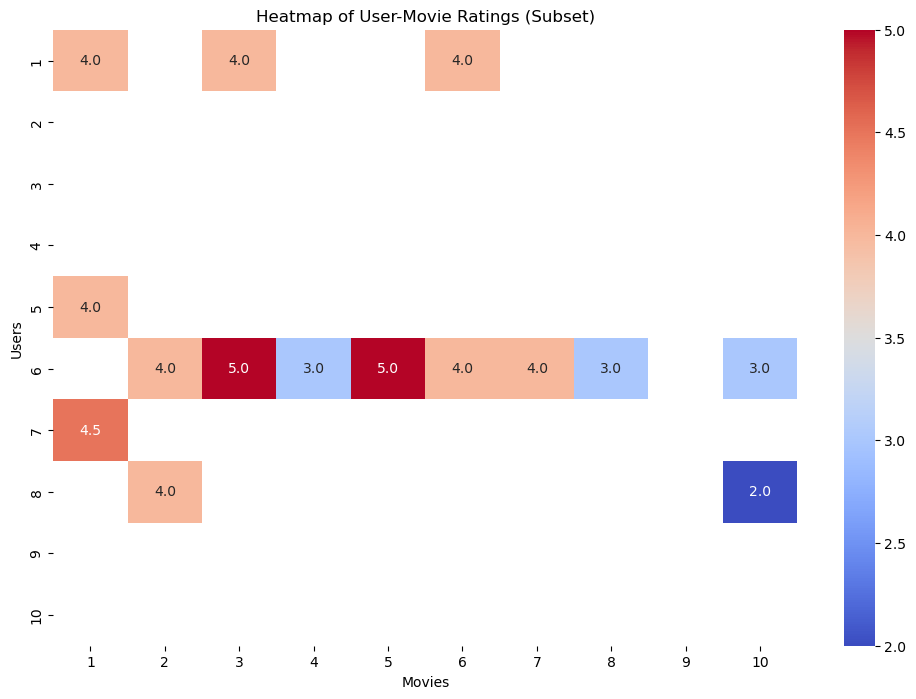

In [50]:
# Generate recommendations for a sample user
sample_user_id = 1
top_recommendations = recommend_movies(sample_user_id, model2, movies_df, ratings_df, top_n=5)

# Display the recommendations
print("Top 5 Recommendations for User 1:")
print(top_recommendations)


import seaborn as sns
import matplotlib.pyplot as plt

user_movie_matrix = ratings_df.pivot(index='userId', columns='movieId',  values='rating')

# Create a smaller subset of the user-movie ratings matrix for visualization
user_movie_subset = user_movie_matrix.iloc[:10, :10]  # Taking the first 10 users and 10 movies

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(user_movie_subset, annot=True, fmt=".1f", cmap="coolwarm", cbar=True)
plt.title("Heatmap of User-Movie Ratings (Subset)")
plt.xlabel("Movies")
plt.ylabel("Users")
plt.show()


## Next Steps

Implement additional evaluation metrics such as **Precision** and **Recall**, although this won't add much value as the matrices itself is sparse. We may want to test for more advanced recommendation models.

Improve diversity and Seredipity, introducing penalization methods for repetitive recommendations to ensure users received diverse movie suggestions.

Implement a feedback loop where users can rate recommendations or mark them as "not interested", allowing continuouse system improvement.

# Conclusion

Using collaborative filtering approach implementing leveraging user-based or item-based similarities to recommend top 5 movies for each user. To address the cold start problem, a hybrid model combines collaborative filtering with content-based filtering, incorporating movie metadata.

To provide personalized movie recommendations, we consider their historical data or the historical data of others based on ratings for new users to ensure tailore recommendations.

The model's performance is assessed using Root Mean Squared Error (RMSE) to measure prediction accuracy. Additionally, due to the sparsity within the matrix, Precision and Recall are not used to evaluate the ranking effectiveness of the recommendations.

This project has significant implications for both businesses and consumers:

**For Businesses**:

* Enhances user retention and engagement by improving content discovery.
* Drives higher revenue through increased watch time and targeted content recommendations.
* Provides valuable insights into user preferences for strategic decision-making.

**For Users**:

* Saves time and effort in finding enjoyable movies.
* Improves overall satisfaction with streaming platforms.
* Encourages exploration of new genres and content.